# Model

In [334]:
! nvidia-smi

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [335]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [336]:
#export
from xview2comp.nb_01b import *

In [337]:
from fastai.vision import models

# Model

### Unet

Use the Unet that is already available in fastai v1 to begin with.

In [338]:
c = 2
sz = 256 #32

In [339]:
encoder = nn.Sequential(*list(models.resnet34().children())[:-2])

In [340]:
model = models.DynamicUnet(encoder, c, (sz, sz))

### Data

Get `DataBunch`, the data object for modeling.  The following lines are from '01_loda_data.ipynb'.

In [341]:
SOURCE = Path('data/')

In [342]:
bs = 8

In [343]:
fnames = get_files(SOURCE/'train'/'images', extensions=['.png',])
print(len(fnames))
fnames = pre_img_fpaths(fnames)[:1000]

xtfms = [ResizeFixed(sz, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor, Normalize(1/255)]
il = ImageList(fnames, path=Path('data/train/images/'), tfms=xtfms)

sd = SplitData.split_by_random(il, val_pct=.1)

ytfms = [ResizeFixed(sz, resample=PIL.Image.NEAREST), to_byte_tensor, to_float_tensor]
ll = label_by_func(sd, img2bmask_fpath, listtype=ImageList, tfms=ytfms)
data = ll.to_databunch(bs, num_workers=0)

5598


In [344]:
xb, yb = next(iter(data.train_dl))

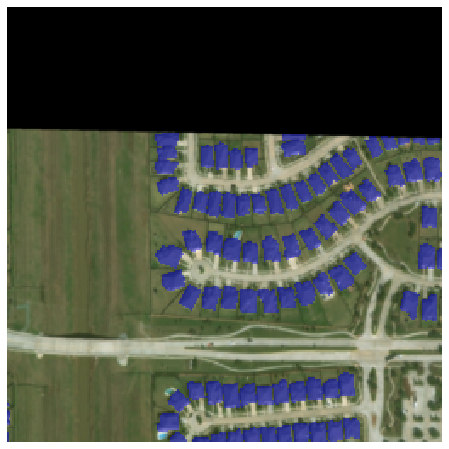

In [345]:
show_sample(xb[6], mas=yb[6], figsize=(8, 8))

### Forward pass through untrained model

Let's pass a mini-batch through the untrained model to make sure that there is no Exception.

In [401]:
pred = model(xb)

In [402]:
pred.shape

torch.Size([8, 2, 256, 256])

In [348]:
def pred2mask(pred): return pred.argmax(dim=1)[:,None,...]

In [349]:
predmask = pred2mask(pred)
predmask.shape, predmask.dtype

(torch.Size([8, 1, 256, 256]), torch.int64)

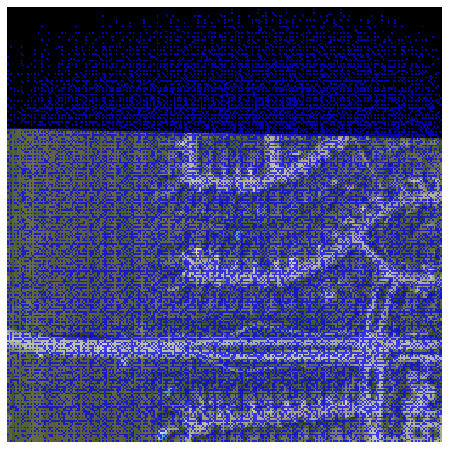

In [351]:
show_sample(xb[6], mas=predmask[6], figsize=(8, 8), alpha=.7)

### Loss function

Flatten out the tensor such that dimension 0 lines up all the pixels in the image/mask, then feed to `nn.CrossEntropyLoss`.

In [352]:
pred.permute(0, 2, 3, 1).reshape(-1, 2).shape

torch.Size([524288, 2])

In [353]:
yb.permute(0, 2, 3, 1).reshape(-1).shape

torch.Size([524288])

In [354]:
class FlattenedCE():
    def __init__(self): self.loss = nn.CrossEntropyLoss()
    def __call__(self, inp, targ):
        inp = inp.permute(0, 2, 3, 1).reshape(-1, 2)
        targ = targ.permute(0, 2, 3, 1).reshape(-1).long()
        return self.loss(inp, targ)

In [355]:
loss_func = FlattenedCE()

In [356]:
loss_func(pred, yb)

tensor(0.8780, grad_fn=<NllLossBackward>)

The following loss functions are copied over from [Dave Luo's notebook on building segmentation](https://nbviewer.jupyter.org/github/daveluo/zanzibar-aerial-mapping/blob/master/geo_fastai_tutorial01_public_v1.ipynb), slightly modified to accommodate the `yb` here.

In [423]:
def dice_loss(inp, targ):
    smooth = 1.
    iflat = inp.sigmoid().contiguous().view(-1).float()
    tflat = targ.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() + smooth))


class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, inp, targ):
        loss = dice_loss(inp, targ)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

In [433]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
        self.reduction = reduction
        
    def forward(self, inp, targ):
        BCE_loss = F.binary_cross_entropy_with_logits(inp, targ.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

In [452]:
class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', 
                 loss_funcs=[FocalLoss(), DiceLoss(),], 
                 loss_wts=[1, 1], ch_wts=[1, 1]):
        super().__init__()
        self.reduction = reduction
        self.lws, self.cws = loss_wts, ch_wts
        self.lossfs = loss_funcs
        
    def forward(self, inp, targ):
        targ = onehot_yb(targ)
        for f in self.lossfs: f.reduction = self.reduction
        loss, nc = 0, inp.shape[1]
        assert len(self.cws) == nc
        assert len(self.lws) == len(self.lossfs)
        for c, cw in enumerate(self.cws):
            ch_loss = 0
            for lw, f in zip(self.lws, self.lossfs): 
                ch_loss += lw * f(inp[:,c,None], targ[:,c,None])
            loss += cw * ch_loss
        return loss / sum(self.cws)

In [451]:
MultiChComboLoss()(pred, yb)

tensor(0.9302, grad_fn=<DivBackward0>)

In [453]:
def onehot_yb(yb):
    return torch.cat([(yb == c).to(torch.float32) for c in yb.unique()], dim=1)

### Metrics

In [454]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask].float() == targ[mask]).float().mean()

In [455]:
foreground_acc(pred, yb, bkg_idx=0, axis=1)

tensor(0.5067)

In [456]:
def seg_acc(inp, targ, axis=1):
    targ = targ.squeeze(1)
    return (inp.argmax(dim=axis).float() == targ).float().mean()

In [457]:
seg_acc(pred, yb)

tensor(0.5654)

The following metrics are imported from Dave Luo's notebook on building segmentation.

In [468]:
def acc_thresh_multich(inp, targ, thresh=.5, sigmoid=True, one_ch=None):
    targ = onehot_yb(targ)
    if sigmoid: inp = inp.sigmoid()
    n = inp.shape[0]
    
    if one_ch is not None:
        inp, targ = inp[:,one_ch,None], targ[:,one_ch,None]
    
    inp = inp.view(n, -1)
    targ = targ.view(n, -1)
    return ((inp > thresh) == targ.bool()).float().mean()

In [461]:
def dice_multich(inp, targ, iou=False, one_ch=None):
    targ = onehot_yb(targ)
    n = targ.shape[0]
    inp = inp.sigmoid()
    
    if one_ch is not None:
        inp, targ = inp[:,one_ch,None], targ[:,one_ch,None]
    
    inp = (inp > .5).view(n, -1).float()
    targ = targ.view(n, -1).float()
    intersect = (inp * targ).sum().float()
    union = (inp + targ).sum().float()
    if not iou:
        return (2 * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union - intersect + 1)

In [469]:
dice_multich(pred, yb), acc_thresh_multich(pred, yb)

(tensor(0.4878), tensor(0.5139))

### Normalize with expected mean and standard deviation 

These image stats for Imagenet are copied from fastai v1.

In [27]:
imagenet_stats = (tensor([0.485, 0.456, 0.406]), 
                  tensor([0.229, 0.224, 0.225]))

In [28]:
def normalize_chan(x, mean, std):
    return (x - mean[...,None,None]) / std[...,None,None]

In [29]:
_m, _s = imagenet_stats
norm_imagenet = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [30]:
partial(BatchTransformXCallback, norm_imagenet)

functools.partial(<class 'exp.nb_06.BatchTransformXCallback'>, functools.partial(<function normalize_chan at 0x7f9e64cb5ef0>, mean=tensor([0.4850, 0.4560, 0.4060], device='cuda:0'), std=tensor([0.2290, 0.2240, 0.2250], device='cuda:0')))

### Learner

`Learner` and `Callback`s make up what's used for the training and validation of the Unet model on the `DataBunch`.  The various definitions for these are slightly scattered among fastai (part2 2019) notebooks, the final versions are gathered here.

In [31]:
cbfs = [partial(BatchTransformXCallback, norm_imagenet), CudaCallback,
        Recorder, ProgressCallback, partial(AvgStatsCallback, seg_acc)]

In [32]:
learn = Learner(model, data, loss_func, lr=1e-1, cb_funcs=cbfs)

In [33]:
learn.fit(1, cbs=[LR_Find(),])

epoch,train_loss,train_seg_acc,valid_loss,valid_seg_acc,time


In [34]:
learn.cbs

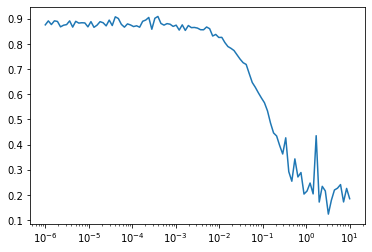

In [35]:
learn.recorder.plot()

In [36]:
lr = 1e-1
pct_start = .5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))

In [37]:
cbsched = [ParamScheduler('lr', sched_lr)]

In [38]:
learn = Learner(model, data, loss_func, lr=1e-1, cb_funcs=cbfs)

In [39]:
learn.fit(5, cbs=cbsched)

epoch,train_loss,train_seg_acc,valid_loss,valid_seg_acc,time
0,0.203048,0.938543,0.176253,0.946151,01:37
1,0.194331,0.938939,0.166836,0.946422,01:38
2,0.183634,0.939634,0.153600,0.947349,01:38
3,0.173175,0.939642,0.148617,0.947126,01:38
4,0.170167,0.940091,0.151518,0.944998,01:38


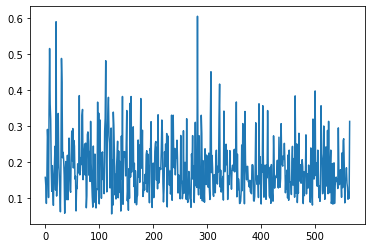

In [40]:
learn.recorder.plot_loss()

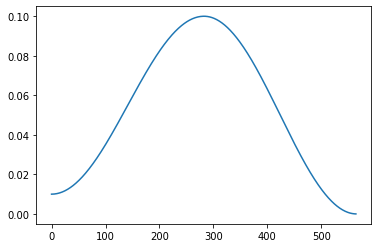

In [41]:
learn.recorder.plot_lr()

### Check input normalization

In [42]:
xb, yb = get_batch(data.train_dl, learn)

epoch,train_loss,train_seg_acc,valid_loss,valid_seg_acc,time


In [43]:
xb.mean(), xb.std()

(tensor(-0.7257, device='cuda:0'), tensor(0.6447, device='cuda:0'))

### Inference

In [44]:
iter_valid_dl = iter(learn.data.valid_dl)

In [45]:
xb, yb = next(iter_valid_dl)
xb = xb.cuda()

In [46]:
xb.shape, yb.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

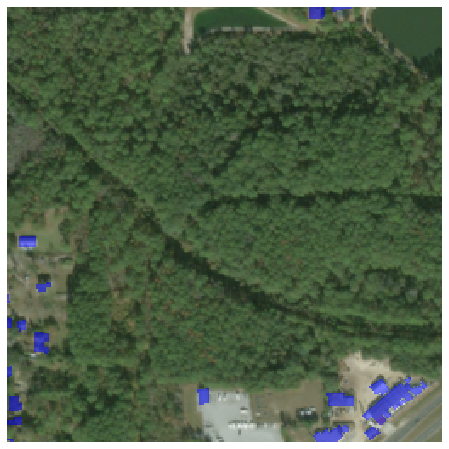

In [53]:
idx = 3
show_sample(xb[idx], mas=yb[idx], figsize=(8, 8), alpha=0.5)

In [54]:
pred = learn.model(xb)

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.43 GiB total capacity; 6.09 GiB already allocated; 87.94 MiB free; 106.62 MiB cached)

In [50]:
predmask = pred2mask(pred)

In [51]:
predmask[idx].unique()

tensor([0], device='cuda:0')

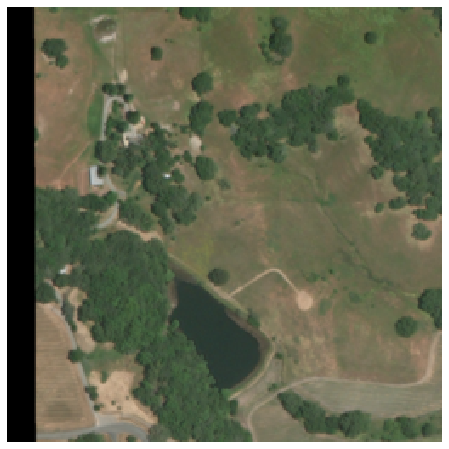

In [52]:
show_sample(xb[idx], mas=predmask[idx], figsize=(8, 8))

### Model serialization

In [49]:
torch.save(learn.model.state_dict(), SOURCE/'nepoch_9__lr_0pt1__sz_516')

In [16]:
learn.model.load_state_dict(torch.load(SOURCE/'nepoch_9__lr_0pt1__sz_516'));

In [35]:
del x, y

In [25]:
valid_dl_iter = iter(data.valid_dl)

In [36]:
x, y = next(valid_dl_iter)

In [41]:
pred = model.cpu()(x.cpu())

In [42]:
pred.argmax(dim=1)[idx][None,...].unique()

tensor([0, 1])

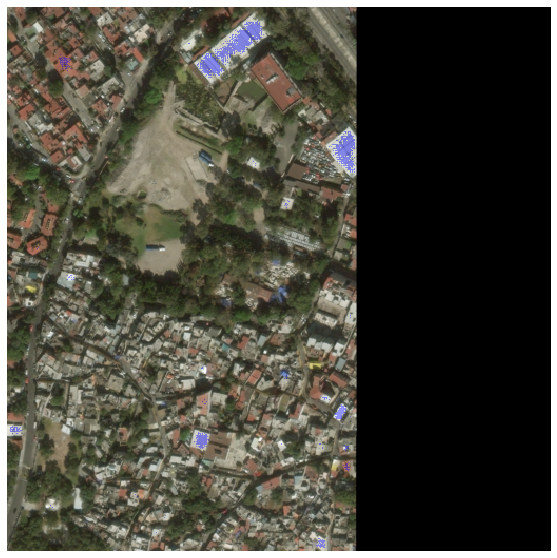

In [43]:
idx = 0
show_sample(x[idx], mas=pred.argmax(dim=1)[idx][None,...], figsize=(10, 10))

# -fin

In [44]:
! python notebook2script.py 02_model.ipynb

Converted 02_model-GCP.ipynb to xview2compgcp/nb_02.py
